<a href="https://colab.research.google.com/github/64RK/cal/blob/main/Stability_API_Initial_Image_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability API - Initial Image Inference

**In this notebook we're going to go over how to use our API to perform an inference call with an initial image that affects our final result.**

In [1]:
#@title <a name="Step 1"><font color="#FFFFFF">1. Install the Stability SDK package.</font></a>

%pip install stability-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.8/409.8 kB 32.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.60.0
    Uninstalling grpcio-1.60.0:
      Successfully uninstalled grpcio-1.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.21.12 which is incompatible.


In [3]:
#@title <a name="Step 2"><font color="#FFFFFF">2. Set up our environment variables and API Key.</font></a>

import getpass, os

# Our host url should not be prepended with "https" nor should it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# Sign up for an account at the following link to get an API Key.
# https://platform.stability.ai/

# Click on the following link once you have created an account to be taken to your API Key.
# https://platform.stability.ai/account/keys

# Paste your API Key below after running this cell.

os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

Enter your API Key··········


In [4]:
#@title <a name="Step 3"><font color="#FFFFFF">3. Import additional dependencies and establish our connection to the API.</font></a>

import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-xl-1024-v1-0", # Set the engine to use for generation.
    # Check out the following link for a list of available engines: https://platform.stability.ai/docs/features/api-parameters#engine
)

INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got answer  with artifact types ['ARTIFACT_IMAGE'] in 9.11s


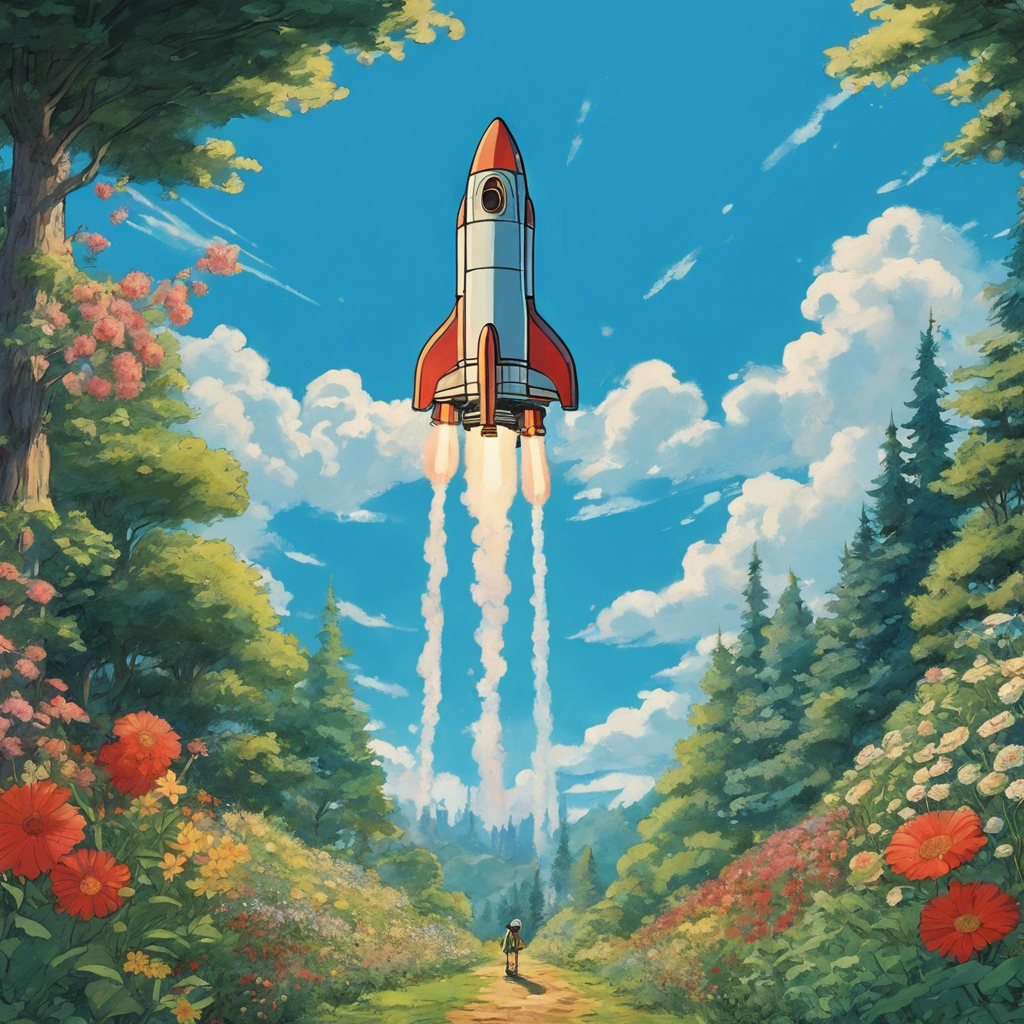

In [5]:
#@title <a name="Step 4"><font color="#FFFFFF">4. Set up initial generation parameters, display image on generation, and safety warning for if the adult content classifier is tripped.</font></a>

# Set up our initial generation parameters.
answers = stability_api.generate(
    prompt="rocket ship launching from forest with flower garden under a blue sky, masterful, ghibli",
    seed=121245125, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

In [ ]:
#@title <a name="Step 5"><font color="#FFFFFF">5. Set up an initial image based on our previous generation, and use a prompt to convert it into a crayon drawing.</font></a>

# Set up our initial generation parameters.
answers = stability_api.generate(
    prompt="crayon drawing of rocket ship launching from forest",
    init_image=img, # Assign our previously generated img as our Initial Image for transformation.
    start_schedule=0.6, # Set the strength of our prompt in relation to our initial image.
    seed=123463446, # If attempting to transform an image that was previously generated with our API,
                    # initial images benefit from having their own distinct seed rather than using the seed of the original image generation.
    steps=50, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=1024, # Generation width, defaults to 512 if not included.
    height=1024, # Generation height, defaults to 512 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

# Set up our warning to print to the console if the adult content classifier is tripped.
# If adult content classifier is not tripped, display generated image.
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary)) # Set our resulting initial image generation as 'img2' to avoid overwriting our previous 'img' generation.
            display(img2)